In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
import torch       

In [35]:
df = pd.read_csv('../DATA/iris.csv')                        

In [36]:
df

sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

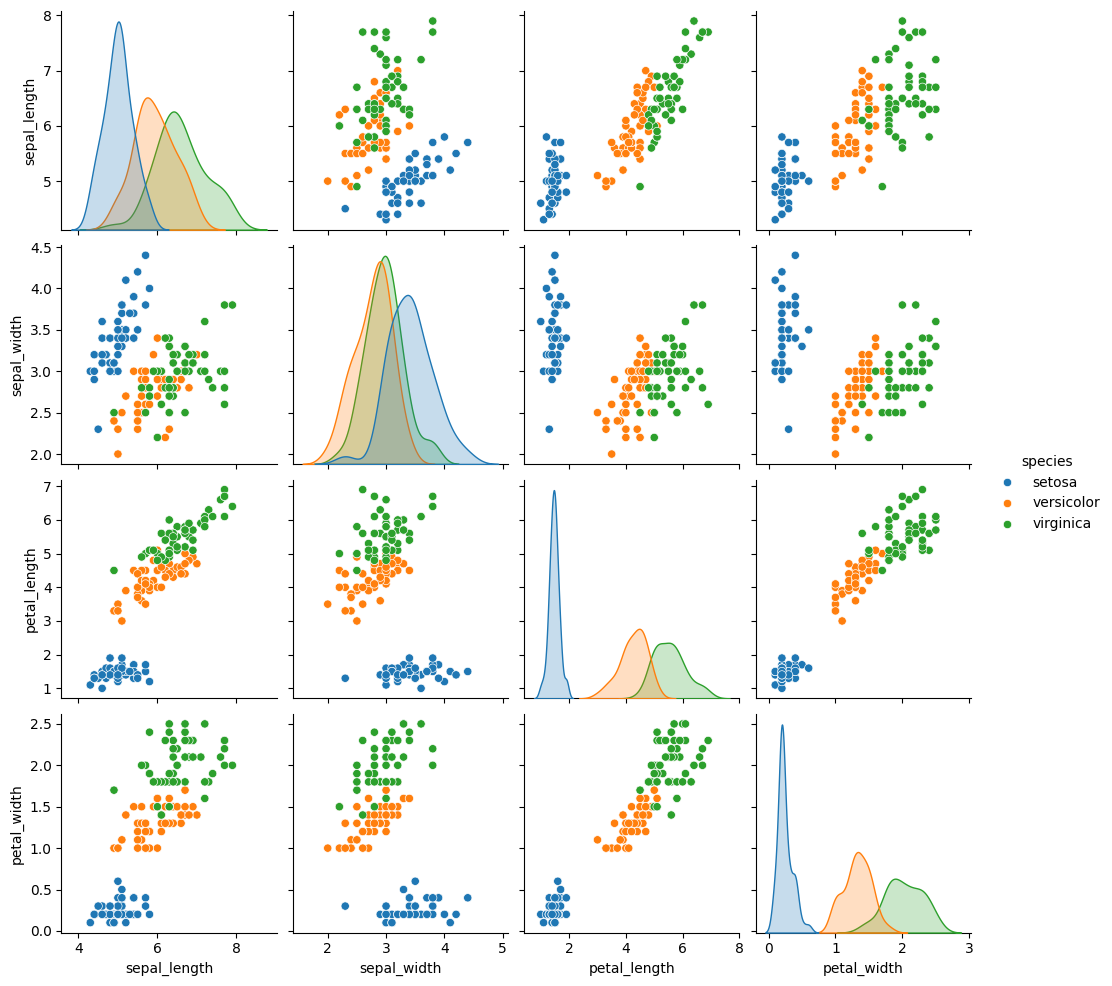

In [37]:
sns.pairplot(data = df , hue = "species")

In [38]:
species_one_hot = pd.get_dummies(df["species"] )  
species_one_hot

setosa  versicolor  virginica
0      True       False      False
1      True       False      False
2      True       False      False
3      True       False      False
4      True       False      False
..      ...         ...        ...
145   False       False       True
146   False       False       True
147   False       False       True
148   False       False       True
149   False       False       True

[150 rows x 3 columns]

In [39]:
df = df.drop("species" , axis = 1)

In [40]:
df = pd.concat([df , species_one_hot] , axis = 1 )

In [41]:
df



sepal_length  sepal_width  petal_length  petal_width  setosa  versicolor  \
0             5.1          3.5           1.4          0.2    True       False   
1             4.9          3.0           1.4          0.2    True       False   
2             4.7          3.2           1.3          0.2    True       False   
3             4.6          3.1           1.5          0.2    True       False   
4             5.0          3.6           1.4          0.2    True       False   
..            ...          ...           ...          ...     ...         ...   
145           6.7          3.0           5.2          2.3   False       False   
146           6.3          2.5           5.0          1.9   False       False   
147           6.5          3.0           5.2          2.0   False       False   
148           6.2          3.4           5.4          2.3   False       False   
149           5.9          3.0           5.1          1.8   False       False   

     virginica  
0        False  
1        False  
2        False  
3        False  
4        False  
..         ...  
145       True  
146       True  
147       True  
148       True  
149       True  

[150 rows x 7 columns]

In [42]:
# converting dataframe to numpy array using .values 
X = df.drop(["setosa", "versicolor" , "virginica"] , axis = 1).values 

In [43]:
# converting dataframe to numpy array using .values 
y = df[["setosa", "versicolor" , "virginica"]].values 

In [44]:
from sklearn.model_selection import train_test_split 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cpu


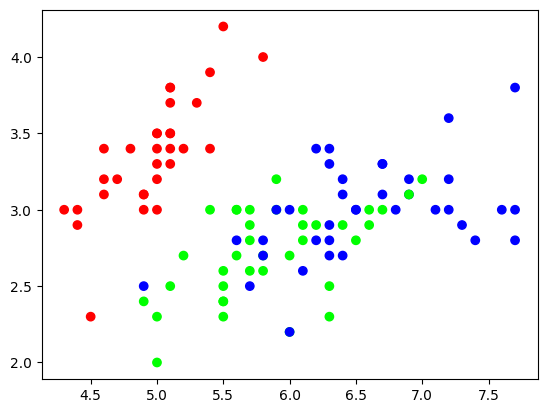

In [46]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}

train_input = X_train
test_input = X_test
train_label = y_train
test_label = y_test

# Ensure labels have the correct shape
train_input = train_input.reshape(train_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)     
train_label = train_label.reshape(train_label.shape[0] , -1)     
test_label = test_label.reshape(test_label.shape[0] , -1)                          

dtype = torch.get_default_dtype()

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(dtype).to(device)   

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [47]:
train_input.shape

(105, 4)

In [48]:
dataset["train_input"].shape

torch.Size([105, 4])

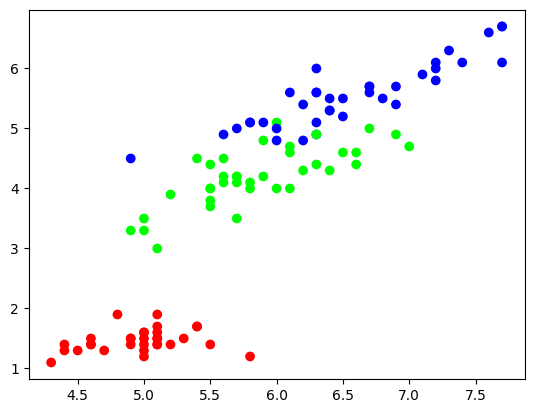

In [49]:
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,2].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

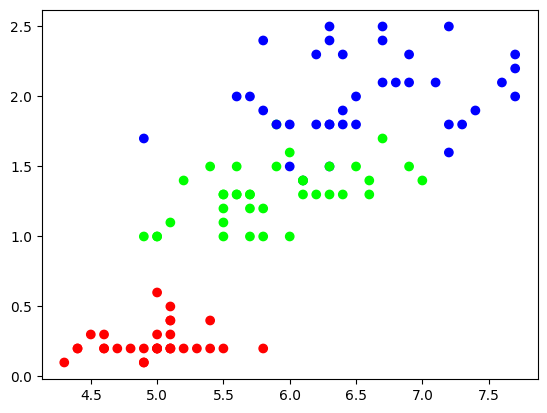

In [50]:
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,3].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [51]:
model = KAN(width=[4 , 3],grid = 3  , k = 3  , device= device) 

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))


def precision(y_true, y_pred):
    # Precision = TP / (TP + FP)
    true_positives = torch.sum((y_pred == 1) & (y_true == 1))
    predicted_positives = torch.sum(y_pred == 1)
    return true_positives / (predicted_positives + 1e-8)  # Add small epsilon to avoid division by zero

def recall(y_true, y_pred):
    # Recall = TP / (TP + FN)
    true_positives = torch.sum((y_pred == 1) & (y_true == 1))
    actual_positives = torch.sum(y_true == 1)
    return true_positives / (actual_positives + 1e-8)

def f1_score(y_true, y_pred):
    # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-8)

def train_f1_score():
    y_pred = torch.round(model(dataset['train_input'])[:, 0])
    y_true = dataset['train_label'][:, 0]                  
    return f1_score(y_true, y_pred)

def test_f1_score():
    y_pred = torch.round(model(dataset['test_input'])[:, 0])
    y_true = dataset['test_label'][:, 0]
    return f1_score(y_true, y_pred)

def train_precision():
    y_pred = torch.round(model(dataset['train_input'])[:, 0])
    y_true = dataset['train_label'][:, 0]
    return precision(y_true, y_pred)

def test_precision():
    y_pred = torch.round(model(dataset['test_input'])[:, 0])
    y_true = dataset['test_label'][:, 0]
    return precision(y_true, y_pred)

def train_recall():
    y_pred = torch.round(model(dataset['train_input'])[:, 0])
    y_true = dataset['train_label'][:, 0]
    return recall(y_true, y_pred)

def test_recall():
    y_pred = torch.round(model(dataset['test_input'])[:, 0])
    y_true = dataset['test_label'][:, 0]
    return recall(y_true, y_pred)

 

results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_f1_score, test_f1_score) );      
results['train_f1_score'][-1], results['test_f1_score'][-1]  
            

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 1.27e-01 | reg: 6.27e+00 | : 100%|█| 50/50 [00:07<00:00,  6.62it

saving model version 0.1


(1.0, 1.0)

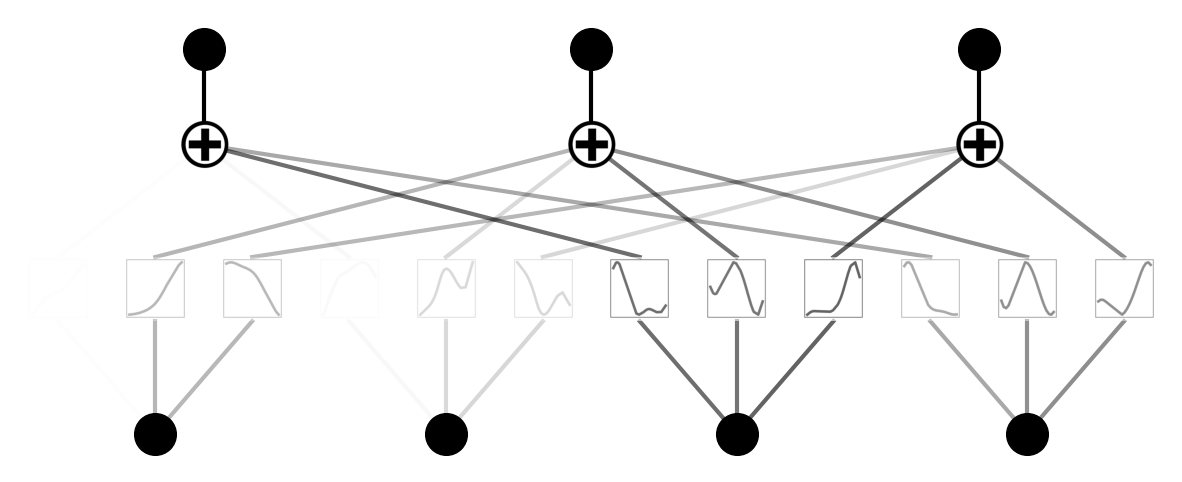

In [52]:
model.plot(scale = 1.5) 

In [53]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)  
formula = model.symbolic_formula()[0][0]   
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9629369974136353, c=1
fixing (0,0,1) with sin, r2=0.996109664440155, c=2
fixing (0,0,2) with x^2, r2=0.994590163230896, c=2
fixing (0,1,0) with x, r2=0.6578536033630371, c=1
fixing (0,1,1) with x, r2=0.43465933203697205, c=1
fixing (0,1,2) with x, r2=0.3847672641277313, c=1
fixing (0,2,0) with x, r2=0.8746959567070007, c=1
fixing (0,2,1) with x, r2=4.7077568865461217e-07, c=1
fixing (0,2,2) with x, r2=0.7175537943840027, c=1
fixing (0,3,0) with x, r2=0.9042080044746399, c=1
fixing (0,3,1) with sin, r2=0.9685757160186768, c=2
fixing (0,3,2) with x, r2=0.5390458703041077, c=1
saving model version 0.2


0.0057*x_1 + 0.0227*x_2 - 0.1633*x_3 - 0.2065*x_4 + 1.118

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 1.26e-01 | reg: 6.27e+00 | : 100%|█| 50/50 [00:05<00:00,  8.38it


saving model version 0.1
saving model version 0.2


| train_loss: 1.32e-01 | test_loss: 1.14e-01 | reg: 6.00e+00 | : 100%|█| 50/50 [00:05<00:00,  8.48it


saving model version 0.3
saving model version 0.4


| train_loss: 1.23e-01 | test_loss: 1.35e-01 | reg: 6.02e+00 | : 100%|█| 50/50 [00:05<00:00,  9.08it


saving model version 0.5
saving model version 0.6


| train_loss: 1.07e-01 | test_loss: 1.49e-01 | reg: 6.32e+00 | : 100%|█| 50/50 [00:05<00:00,  8.84it


saving model version 0.7
saving model version 0.8


| train_loss: 1.17e-01 | test_loss: 1.42e-01 | reg: 6.21e+00 | : 100%|█| 50/50 [00:07<00:00,  7.13it


saving model version 0.9
saving model version 0.10


| train_loss: 9.11e-02 | test_loss: 1.91e-01 | reg: 7.16e+00 | : 100%|█| 50/50 [00:06<00:00,  7.83it


saving model version 0.11
saving model version 0.12


| train_loss: 9.05e-02 | test_loss: 1.86e-01 | reg: 7.24e+00 | : 100%|█| 50/50 [00:06<00:00,  8.24it


saving model version 0.13
saving model version 0.14


| train_loss: 7.39e-02 | test_loss: 2.10e-01 | reg: 7.84e+00 | : 100%|█| 50/50 [00:05<00:00,  8.98it


saving model version 0.15
saving model version 0.16


| train_loss: 6.60e-02 | test_loss: 2.86e-01 | reg: 8.41e+00 | : 100%|█| 50/50 [00:06<00:00,  7.55it


saving model version 0.17
saving model version 0.18


| train_loss: 5.45e-02 | test_loss: 3.27e-01 | reg: 8.43e+00 | : 100%|█| 50/50 [00:05<00:00,  8.52it


saving model version 0.19
saving model version 0.20


| train_loss: 6.20e-02 | test_loss: 3.02e-01 | reg: 8.46e+00 | : 100%|█| 50/50 [00:06<00:00,  8.10it


saving model version 0.21


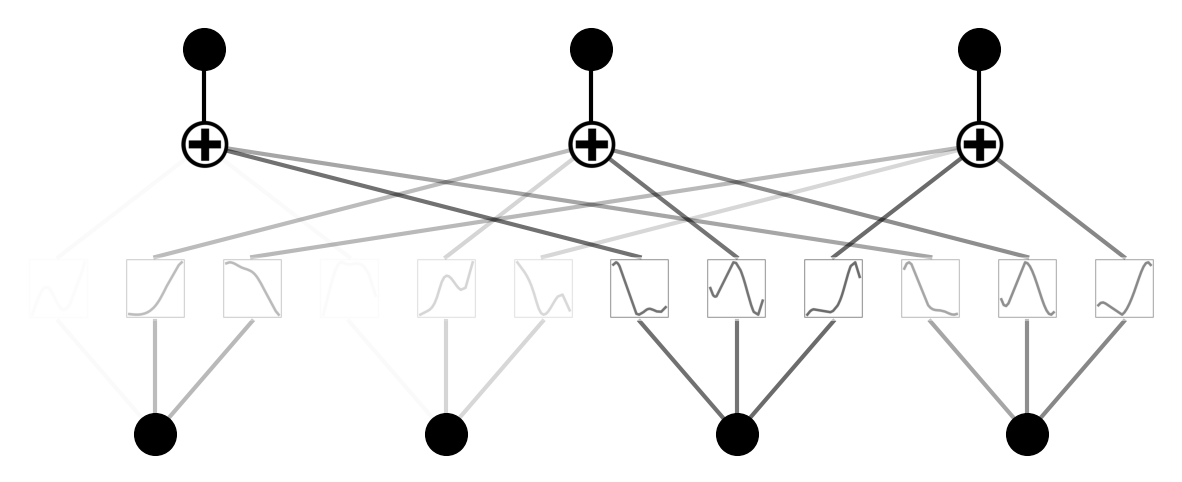

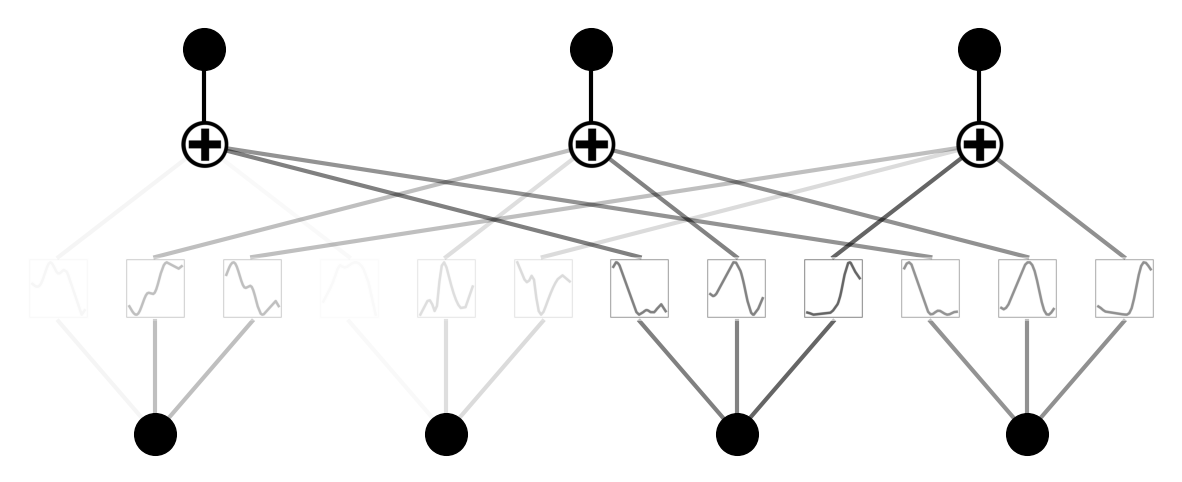

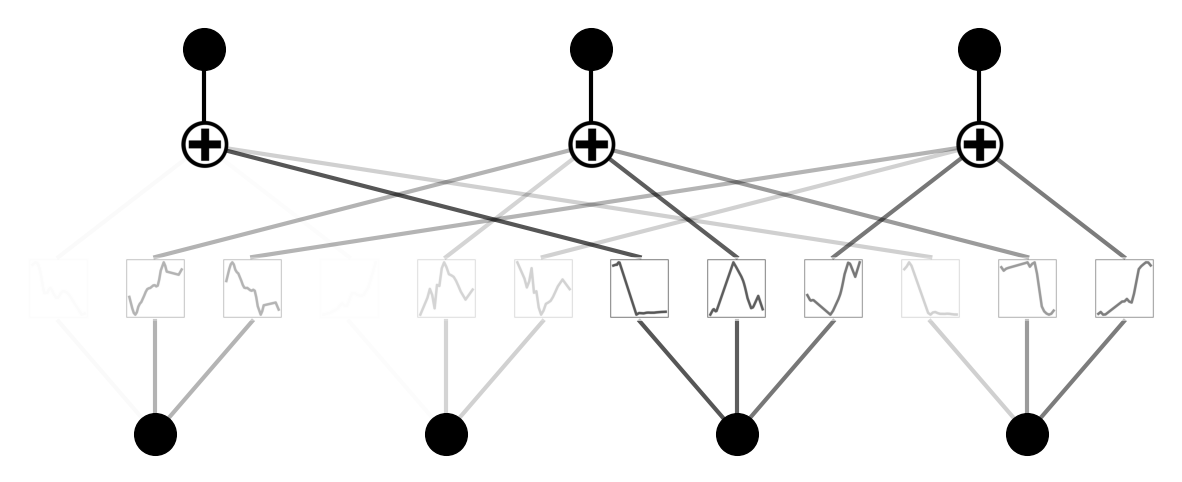

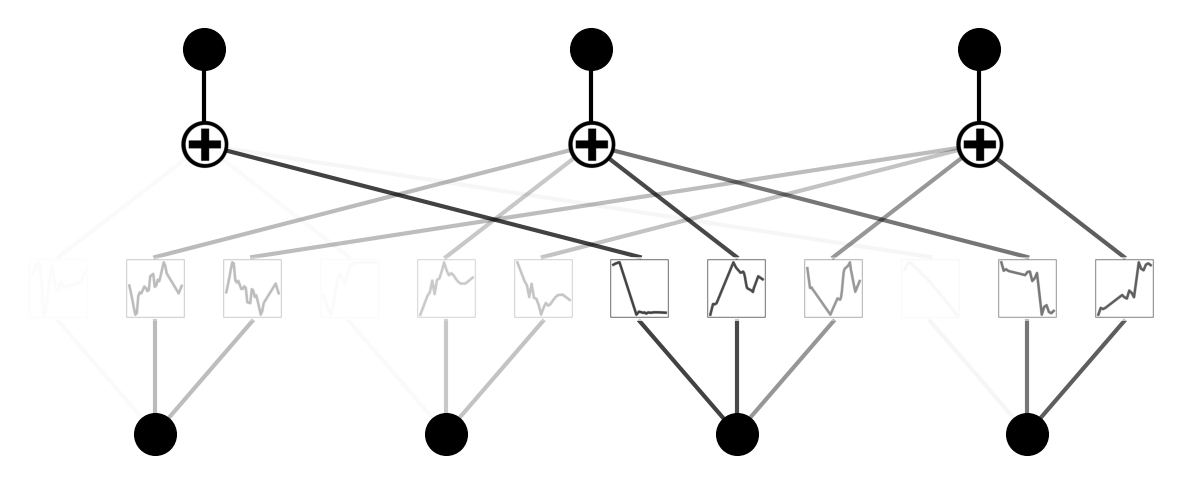

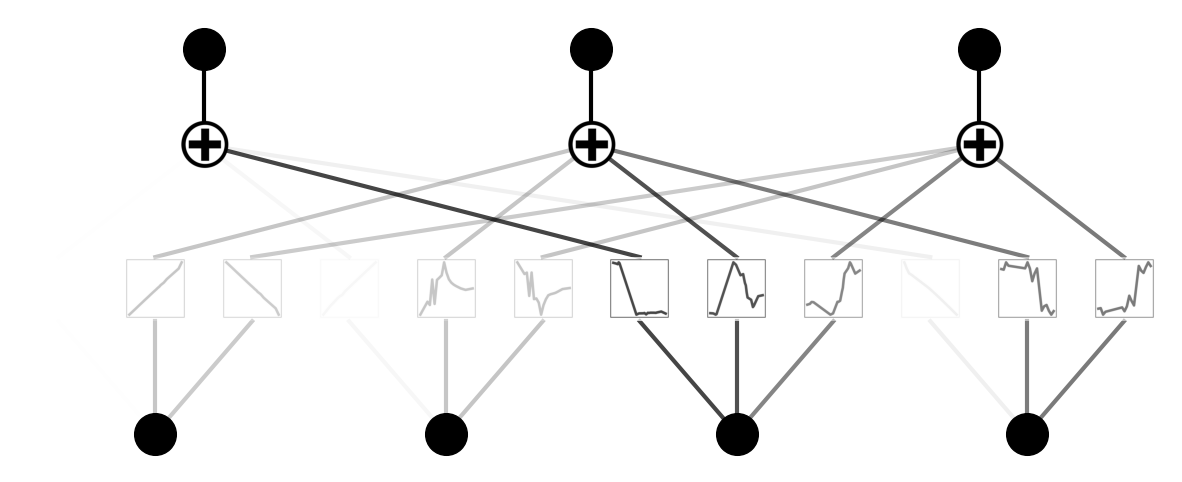

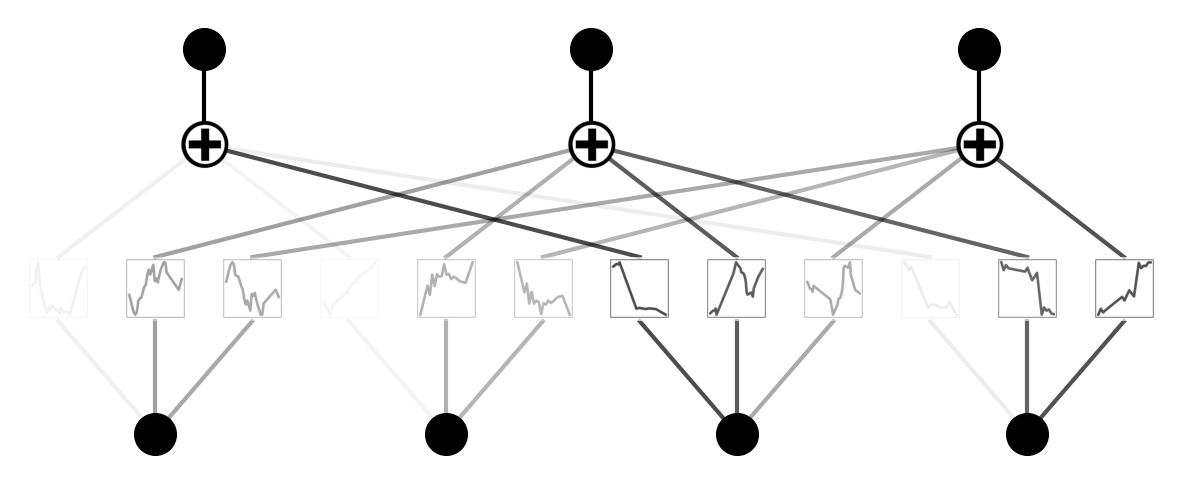

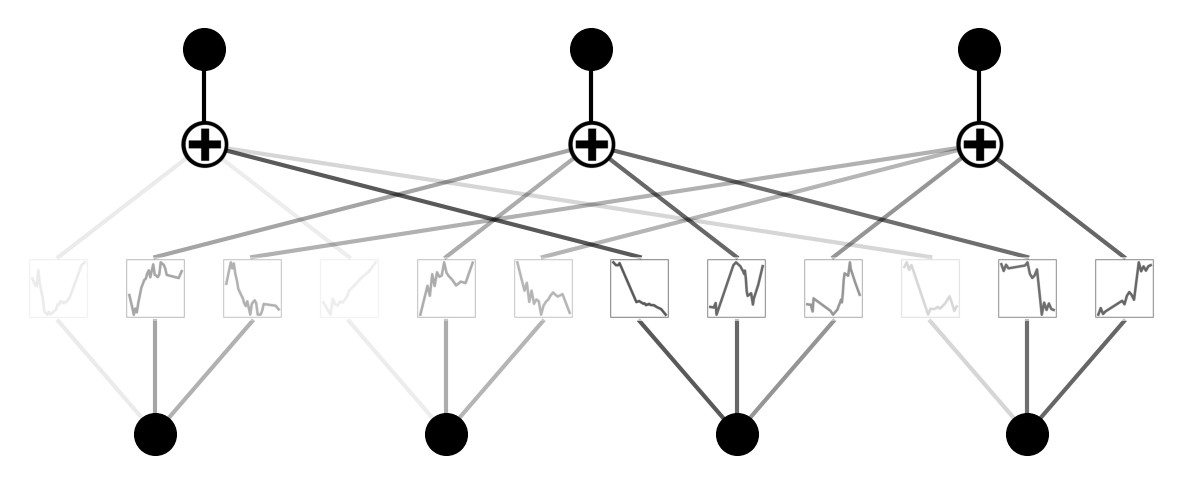

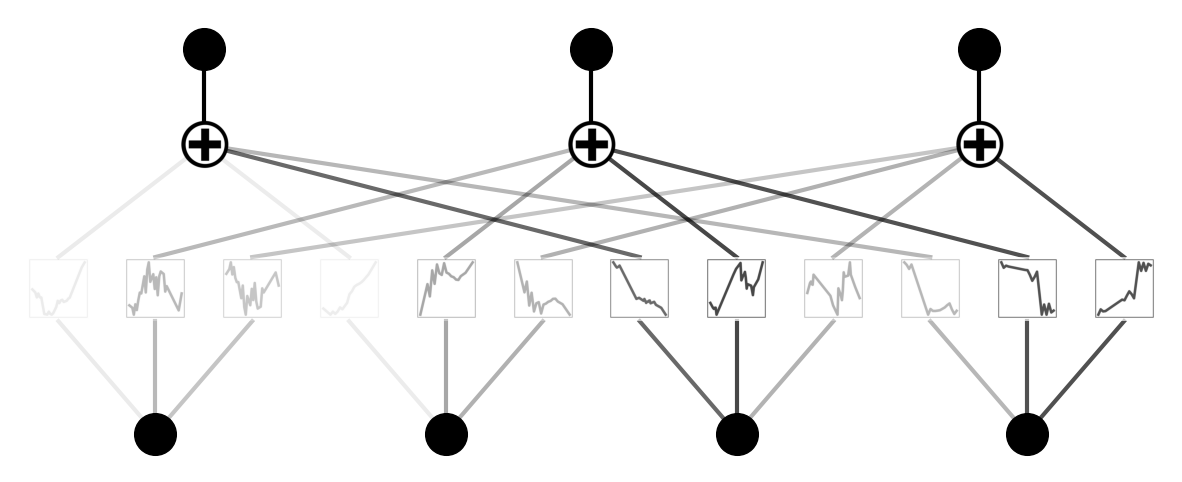

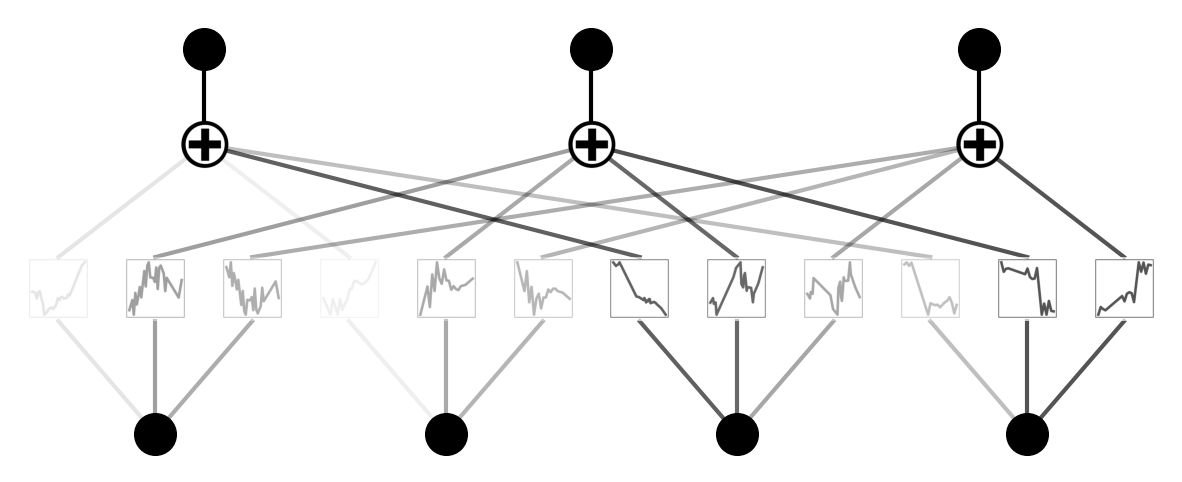

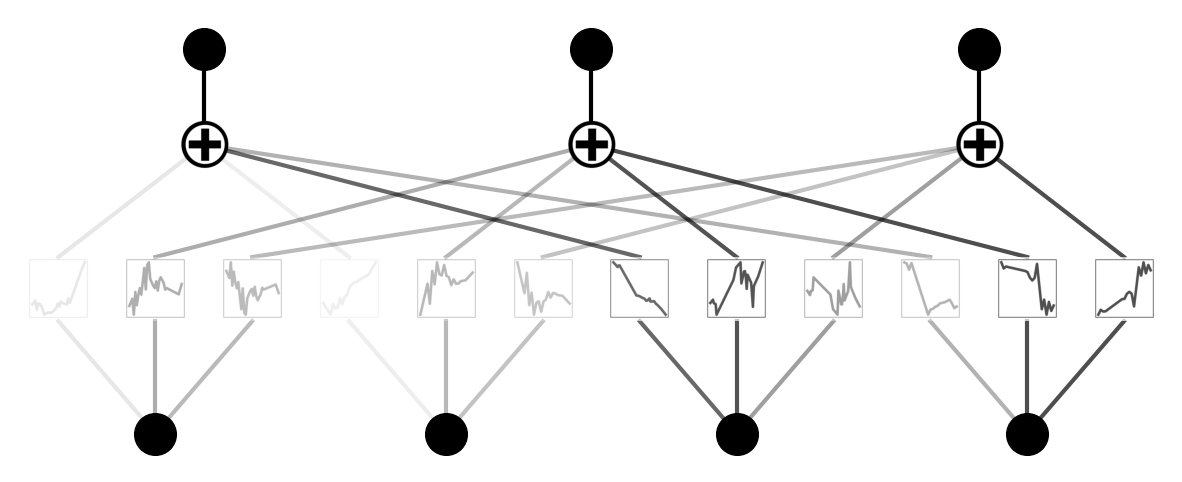

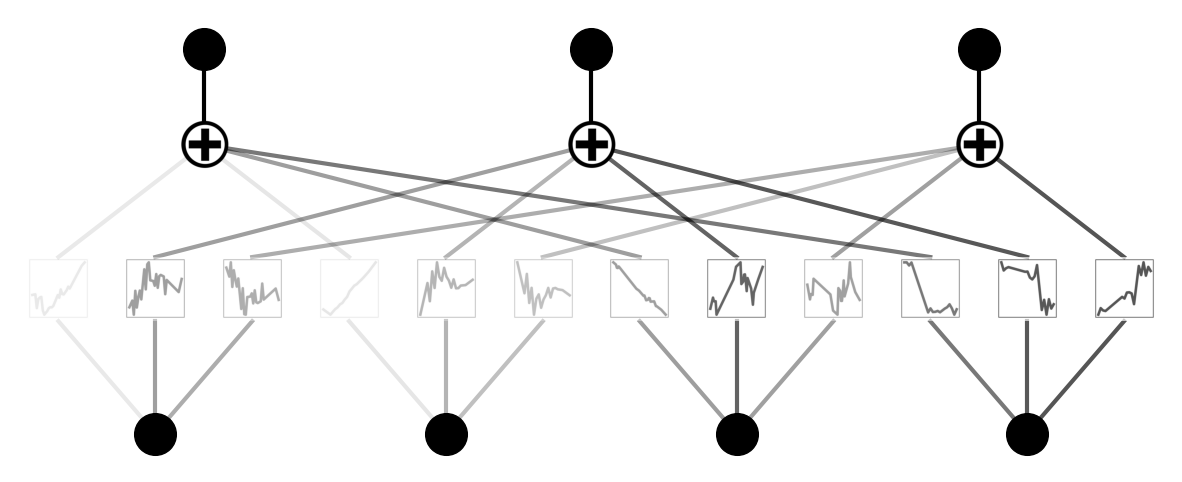

In [54]:
grids = np.array([3, 5 ,10 ,15 , 20 , 25 , 30 , 35 , 40 , 45 , 50  ])

train_f1_score_list = []
test_f1_score_list = []  

train_losses = []
test_losses = []
steps = 50 
k = 3

for i in range(grids.shape[0]):

    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))
    
    def precision(y_true, y_pred):
        # Precision = TP / (TP + FP)
        true_positives = torch.sum((y_pred == 1) & (y_true == 1))
        predicted_positives = torch.sum(y_pred == 1)
        return true_positives / (predicted_positives + 1e-8)  # Add small epsilon to avoid division by zero

    def recall(y_true, y_pred):
        # Recall = TP / (TP + FN)
        true_positives = torch.sum((y_pred == 1) & (y_true == 1))
        actual_positives = torch.sum(y_true == 1)
        return true_positives / (actual_positives + 1e-8)

    def f1_score(y_true, y_pred):
        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        prec = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return 2 * (prec * rec) / (prec + rec + 1e-8)

    def train_f1_score():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]                  
        return f1_score(y_true, y_pred)

    def test_f1_score():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return f1_score(y_true, y_pred)

    def train_precision():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]
        return precision(y_true, y_pred)

    def test_precision():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return precision(y_true, y_pred)

    def train_recall():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]
        return recall(y_true, y_pred)

    def test_recall():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return recall(y_true, y_pred)
        
    if i == 0:
        model = KAN(width=[4 , 3 ], grid=grids[i], k=k, seed=1, device=device)     
        
    if i != 0:
        model = model.refine(grids[i])    
        

        
        
    results = model.fit(dataset, opt="LBFGS", steps=steps , metrics = (train_f1_score , test_f1_score))                     
    train_losses += results['train_loss']   
    test_losses += results['test_loss']   
                     
    train_f1_score_list.append(results['train_f1_score'][-1])
    test_f1_score_list.append(results['test_f1_score'][-1])   
    
    model.plot(scale = 1.5)              
    

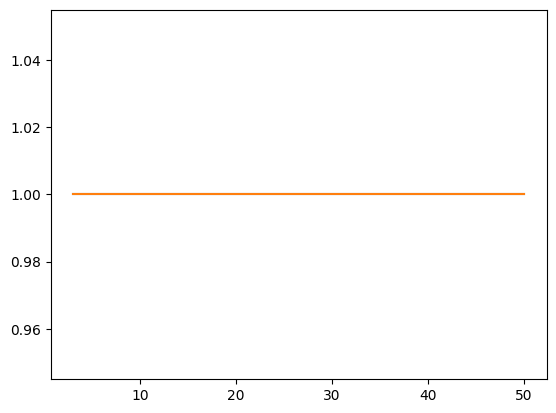

In [55]:
plt.plot(grids , train_f1_score_list)
plt.plot(grids , test_f1_score_list)    

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 5.09e-01 | reg: 6.89e+00 | : 100%|█| 50/50 [00:05<00:00,  8.85it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 1.09e-01 | reg: 6.11e+00 | : 100%|█| 50/50 [00:05<00:00,  8.60it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 1.27e-01 | reg: 6.27e+00 | : 100%|█| 50/50 [00:09<00:00,  5.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 1.13e-01 | reg: 5.93e+00 | : 100%|█| 50/50 [00:11<00:00,  4.49it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 1.17e-01 | reg: 6.14e+00 | : 100%|█| 50/50 [00:12<00:00,  4.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 1.13e-01 | reg: 6.23e+00 | : 100%|█| 50/50 [00:13<00:00,  3.80it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 1.18e-01 | reg: 6.17e+00 | : 100%|█| 50/50 [00:10<00:00,  4.78it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 1.28e-01 | reg: 6.60e+00 | : 100%|█| 50/50 [00:08<00:00,  5.69it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 1.35e-01 | reg: 6.78e+00 | : 100%|█| 50/50 [00:09<00:00,  5.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 1.27e-01 | reg: 6.42e+00 | : 100%|█| 50/50 [00:12<00:00,  4.15it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 1.26e-01 | reg: 6.47e+00 | : 100%|█| 50/50 [00:16<00:00,  3.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 1.46e-01 | reg: 6.91e+00 | : 100%|█| 50/50 [00:13<00:00,  3.63it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 1.35e-01 | reg: 6.69e+00 | : 100%|█| 50/50 [00:10<00:00,  4.67it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 1.50e-01 | reg: 6.91e+00 | : 100%|█| 50/50 [00:18<00:00,  2.75it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 1.59e-01 | reg: 7.23e+00 | : 100%|█| 50/50 [00:19<00:00,  2.61it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 1.51e-01 | reg: 6.72e+00 | : 100%|█| 50/50 [00:19<00:00,  2.53it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 1.50e-01 | reg: 6.33e+00 | : 100%|█| 50/50 [00:20<00:00,  2.47it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 1.50e-01 | reg: 6.57e+00 | : 100%|█| 50/50 [00:21<00:00,  2.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 1.44e-01 | reg: 6.56e+00 | : 100%|█| 50/50 [00:22<00:00,  2.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 1.65e-01 | reg: 6.48e+00 | : 100%|█| 50/50 [00:22<00:00,  2.20it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 1.51e-01 | reg: 6.60e+00 | : 100%|█| 50/50 [00:23<00:00,  2.15it
c:\Users\gaurav\Desktop\KAN NETWORKS\pykan-master\pykan-master\tutorials\.ipynb_checkpoints\my_models\kan\MultKAN.py:1081: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(w_large, w_large))


saving model version 0.1


c:\Users\gaurav\Desktop\KAN NETWORKS\pykan-master\pykan-master\tutorials\.ipynb_checkpoints\my_models\kan\MultKAN.py:1158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0+z0)))


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 1.54e-01 | reg: 6.19e+00 | : 100%|█| 50/50 [00:24<00:00,  2.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 1.53e-01 | reg: 6.72e+00 | : 100%|█| 50/50 [00:22<00:00,  2.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 1.55e-01 | reg: 6.78e+00 | : 100%|█| 50/50 [00:14<00:00,  3.57it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 1.58e-01 | reg: 6.48e+00 | : 100%|█| 50/50 [00:13<00:00,  3.60it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 1.57e-01 | reg: 6.73e+00 | : 100%|█| 50/50 [00:17<00:00,  2.80it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 1.68e-01 | reg: 5.76e+00 | : 100%|█| 50/50 [00:19<00:00,  2.50it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 1.60e-01 | reg: 6.62e+00 | : 100%|█| 50/50 [00:21<00:00,  2.36it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 1.63e-01 | reg: 6.23e+00 | : 100%|█| 50/50 [00:20<00:00,  2.46it


saving model version 0.1


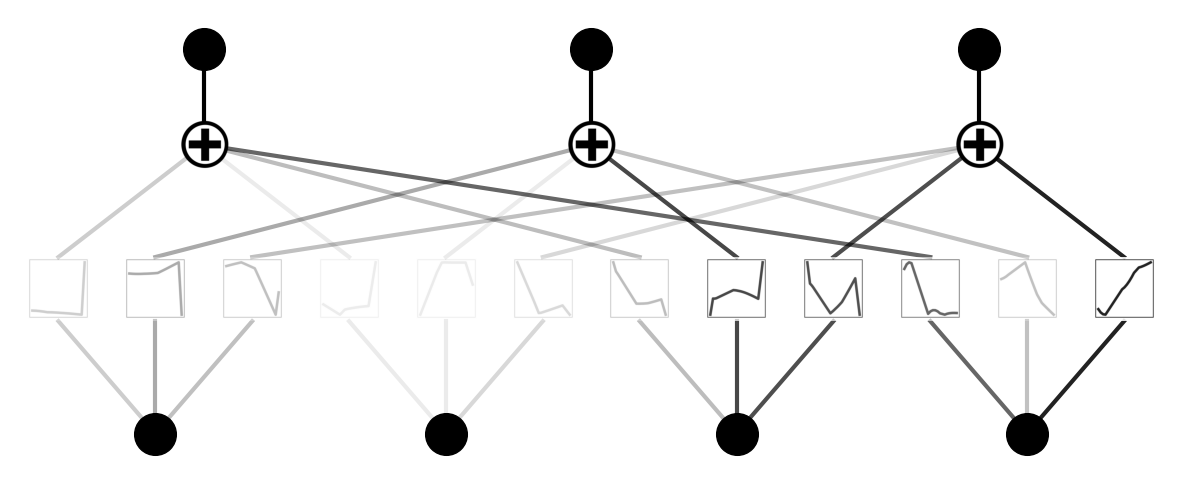

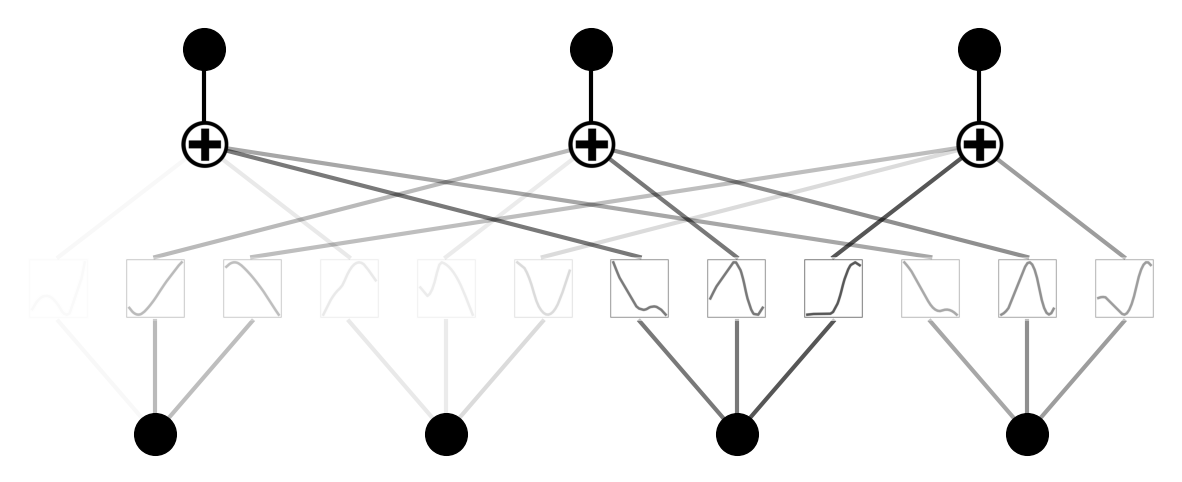

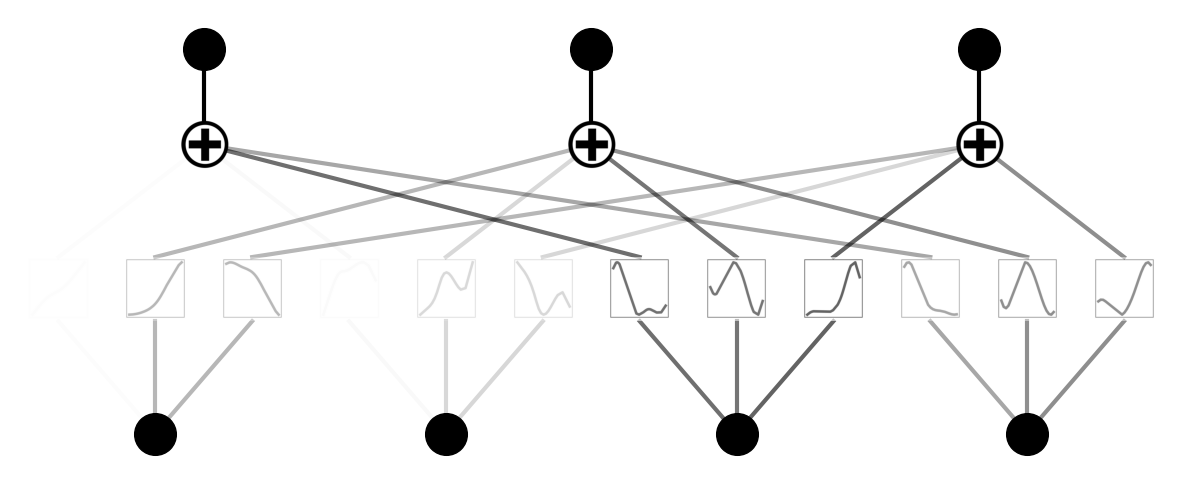

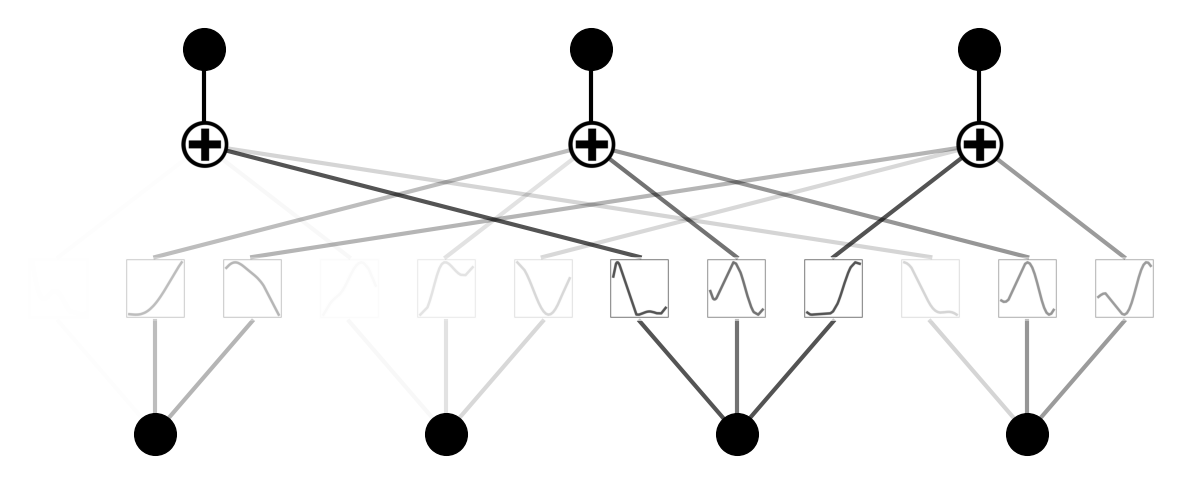

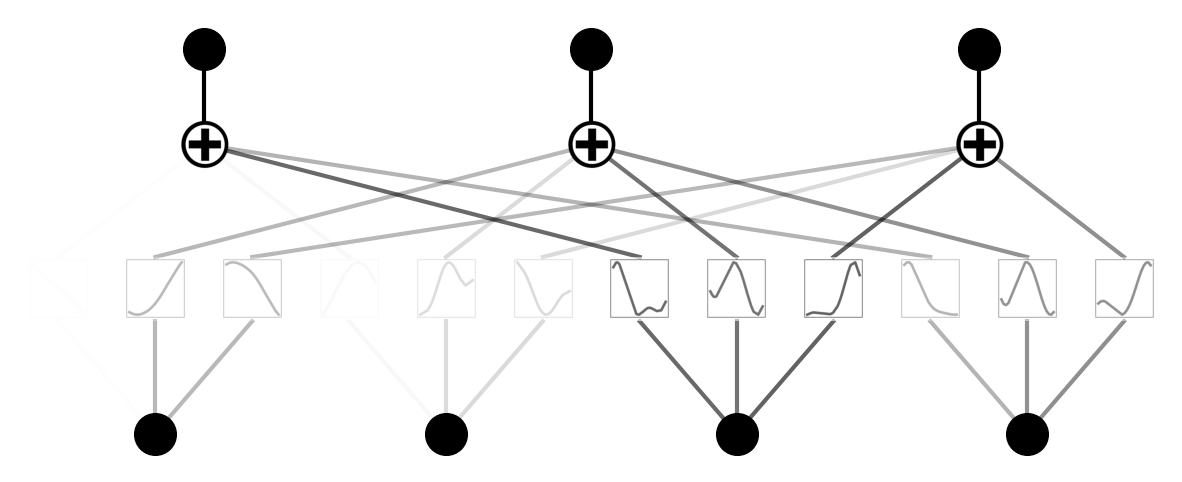

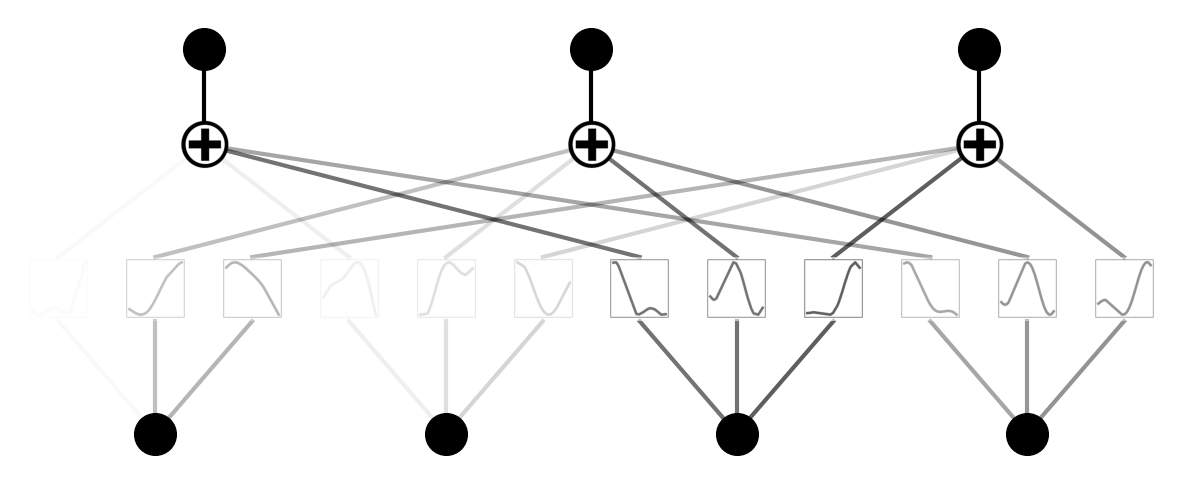

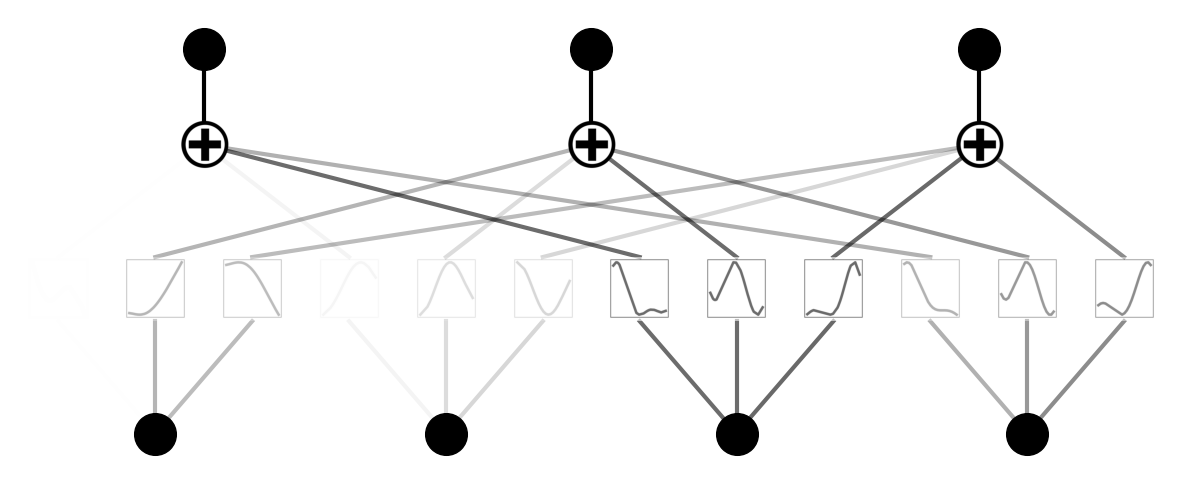

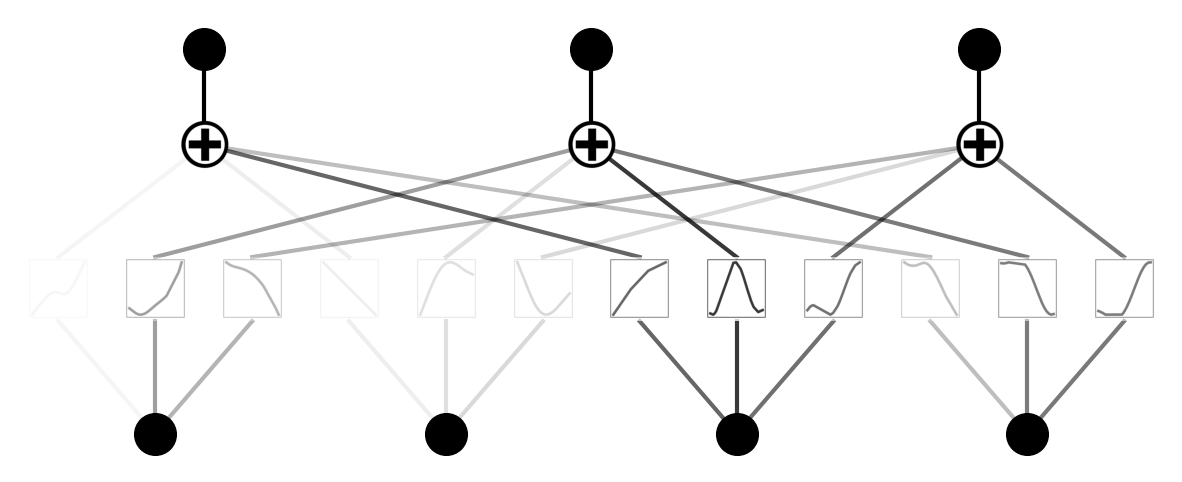

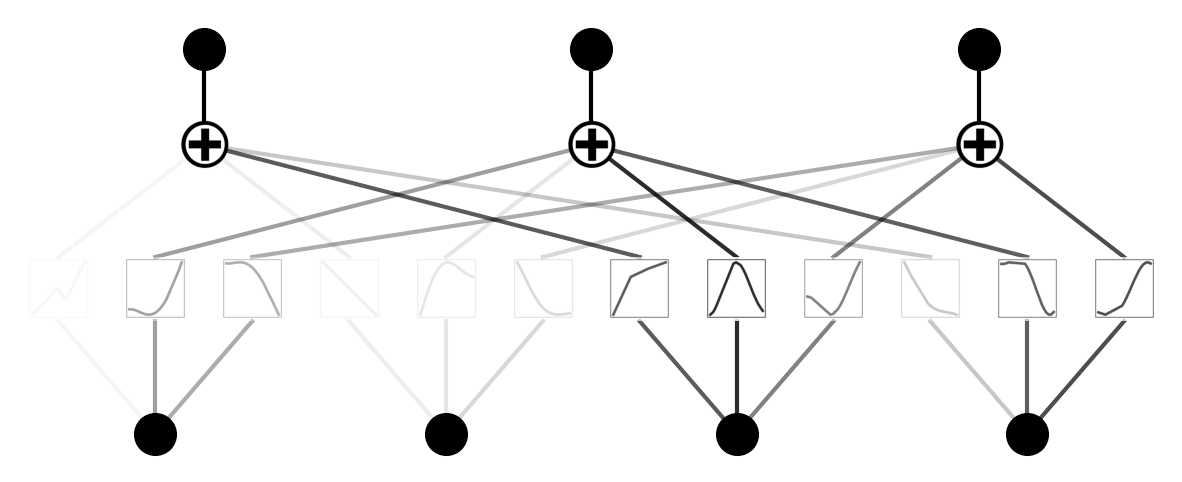

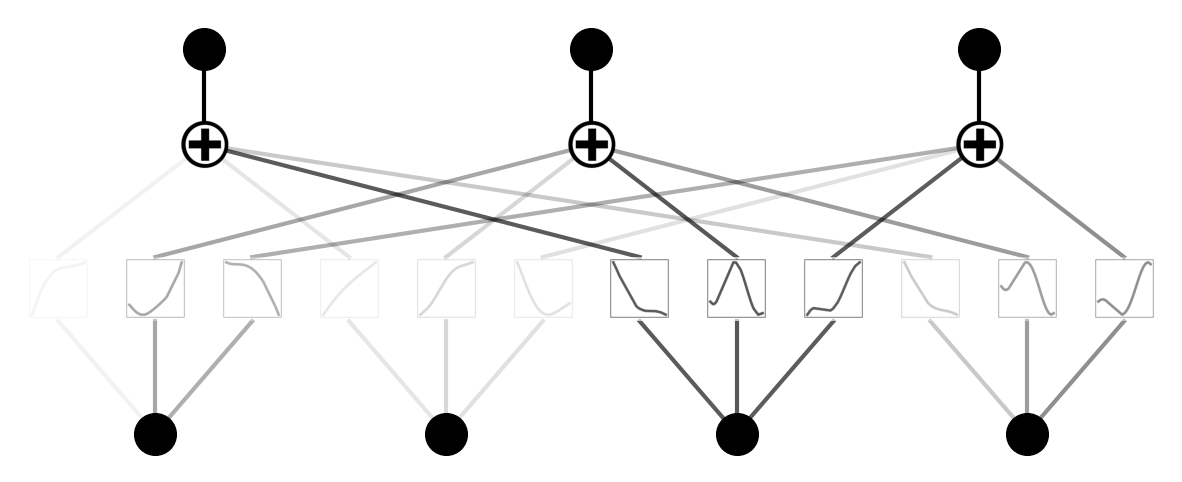

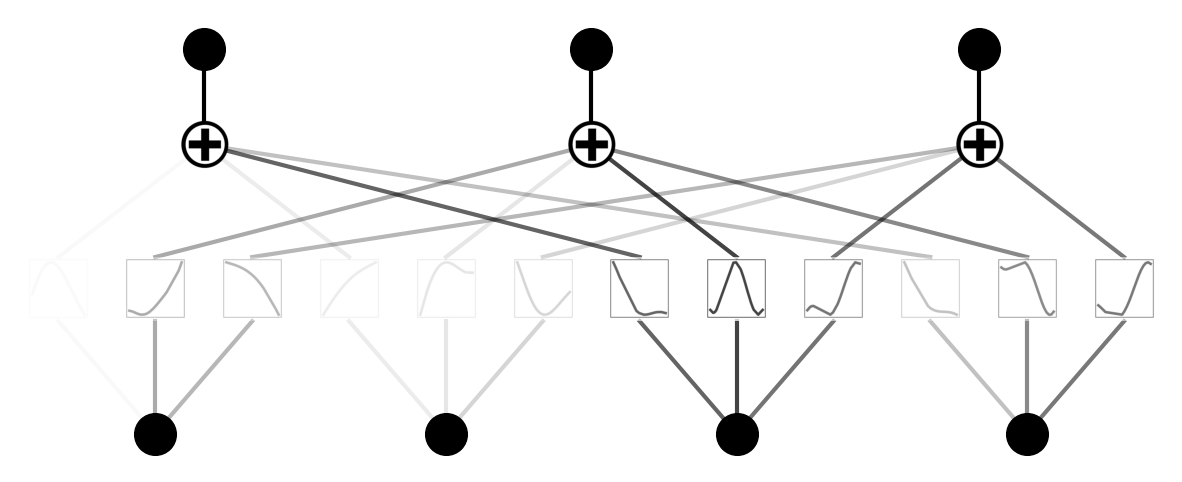

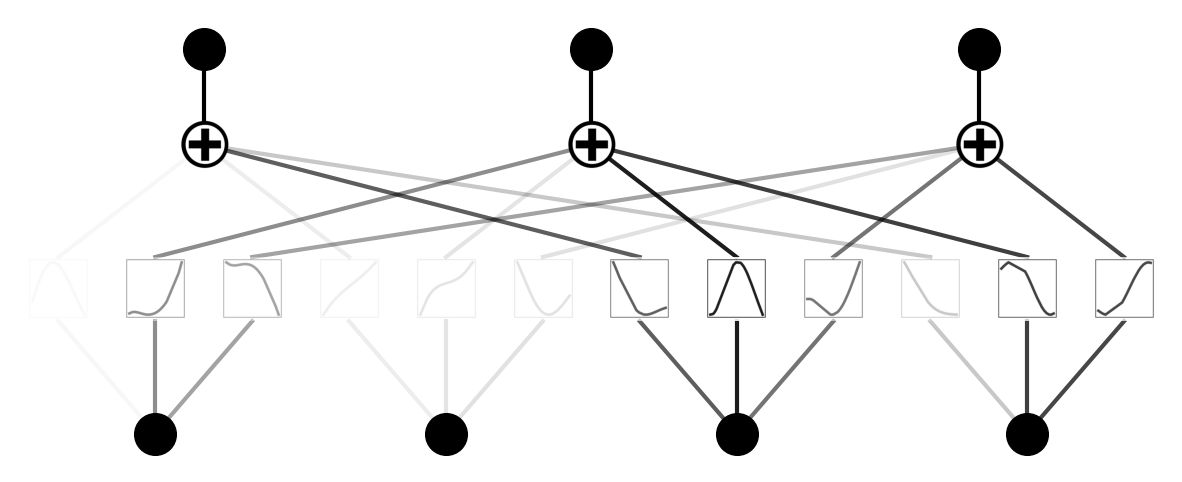

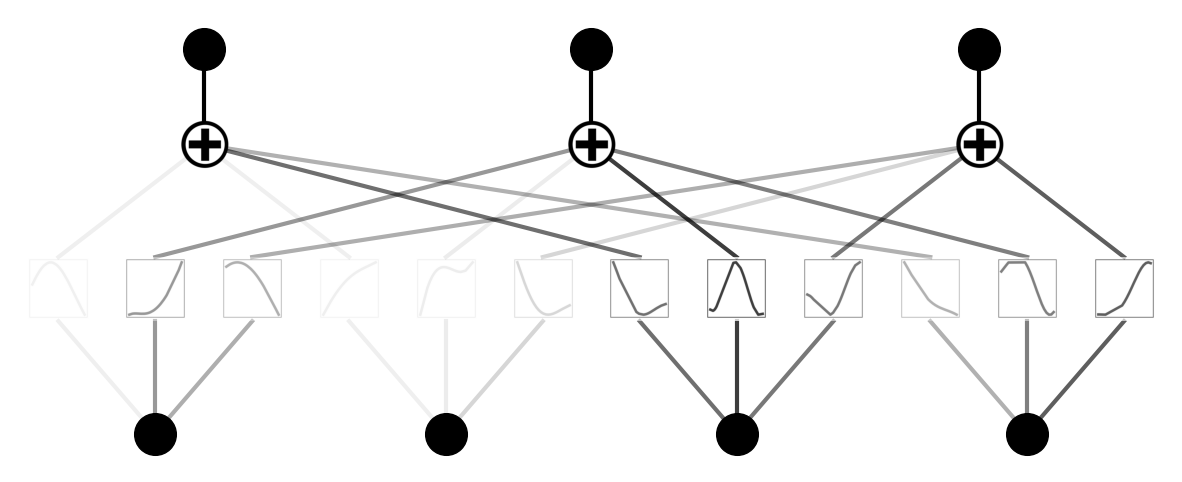

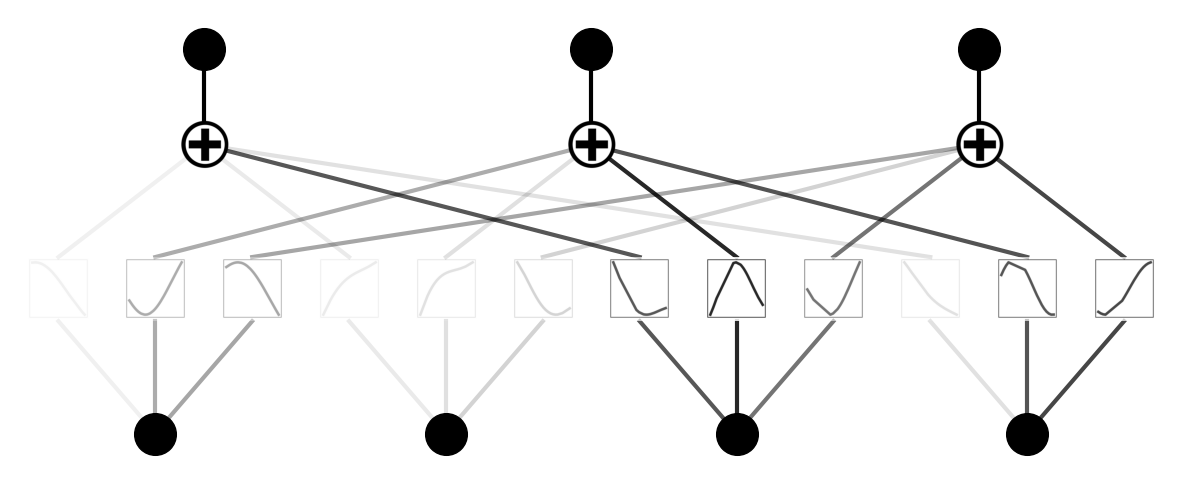

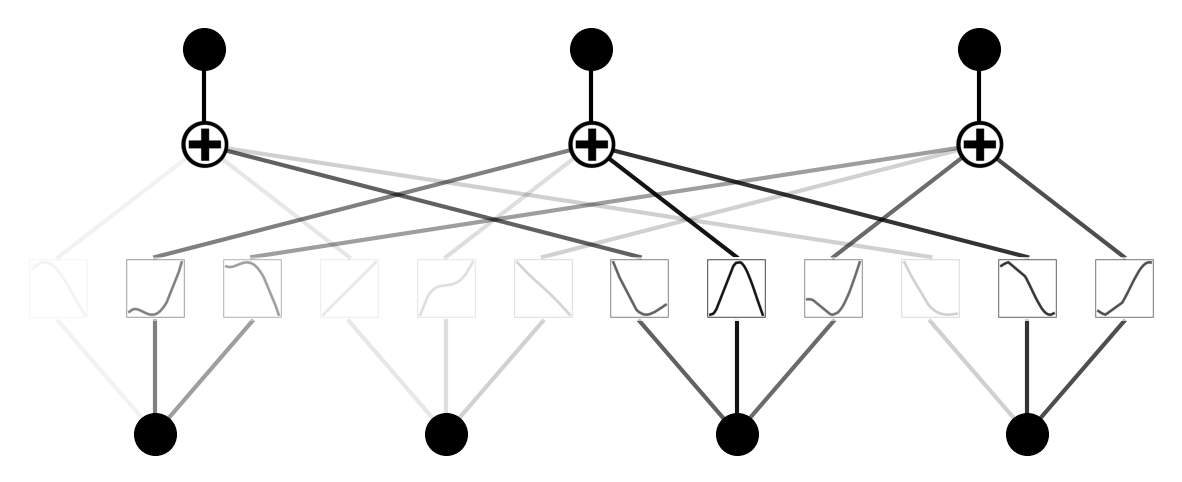

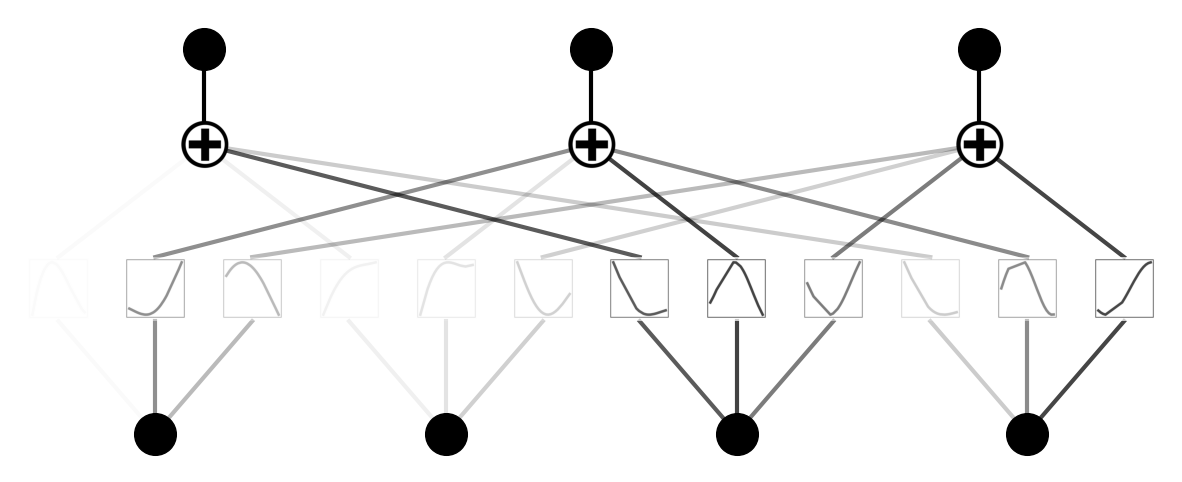

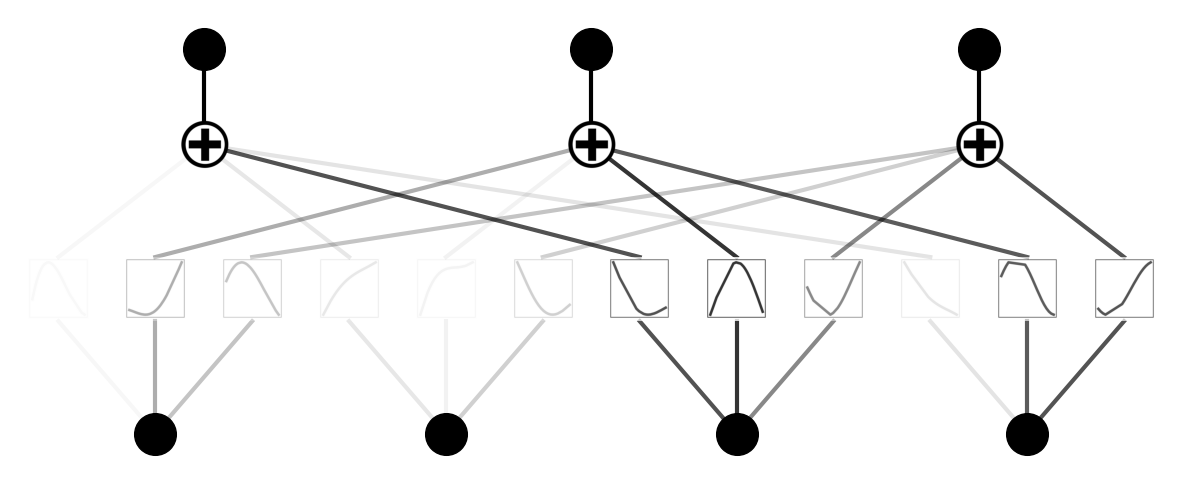

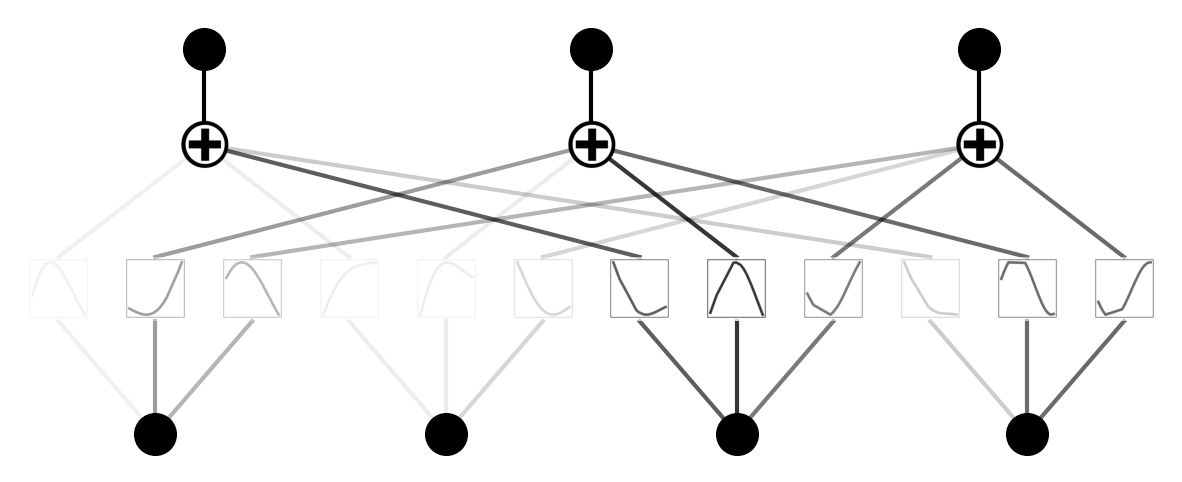

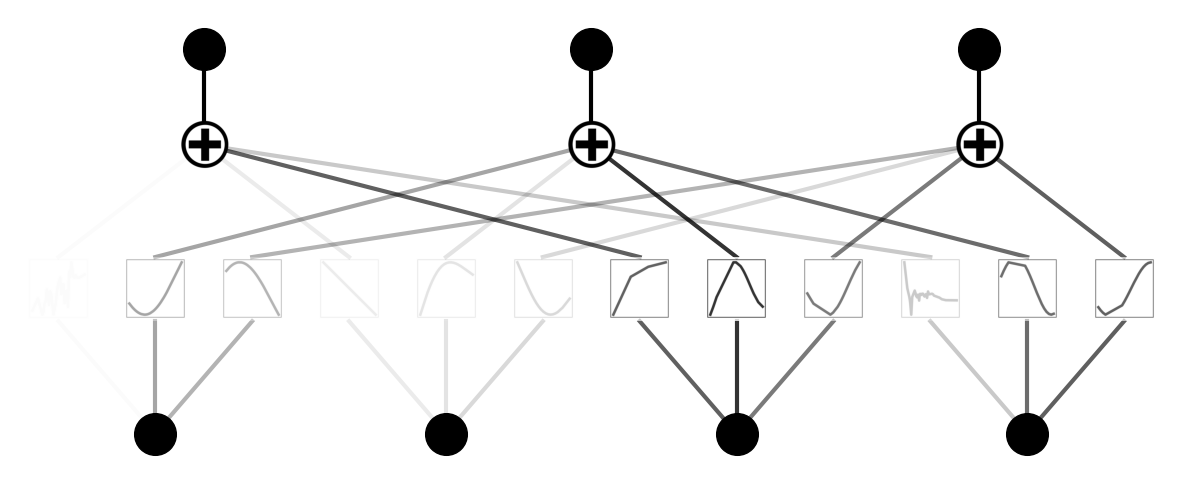

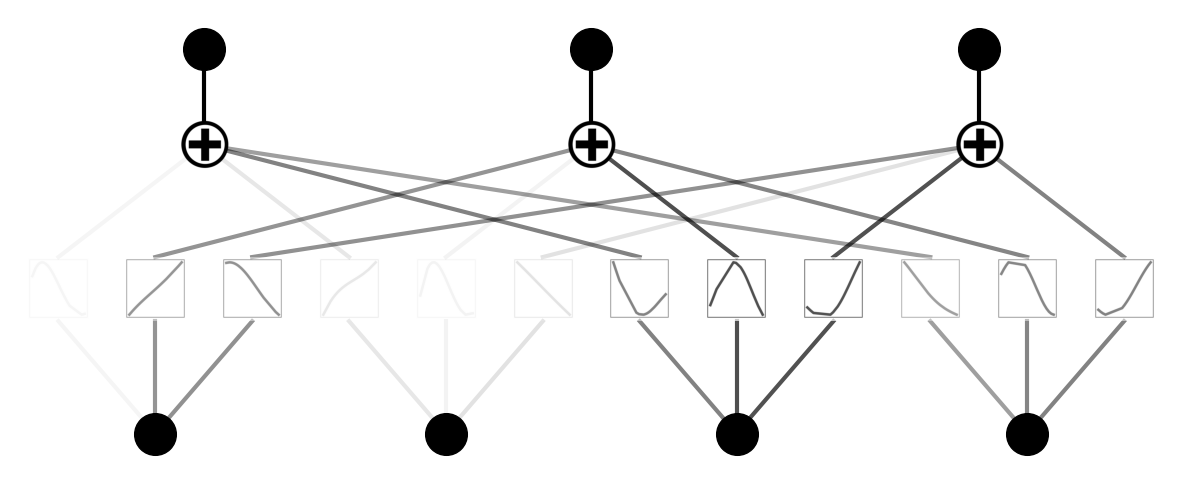

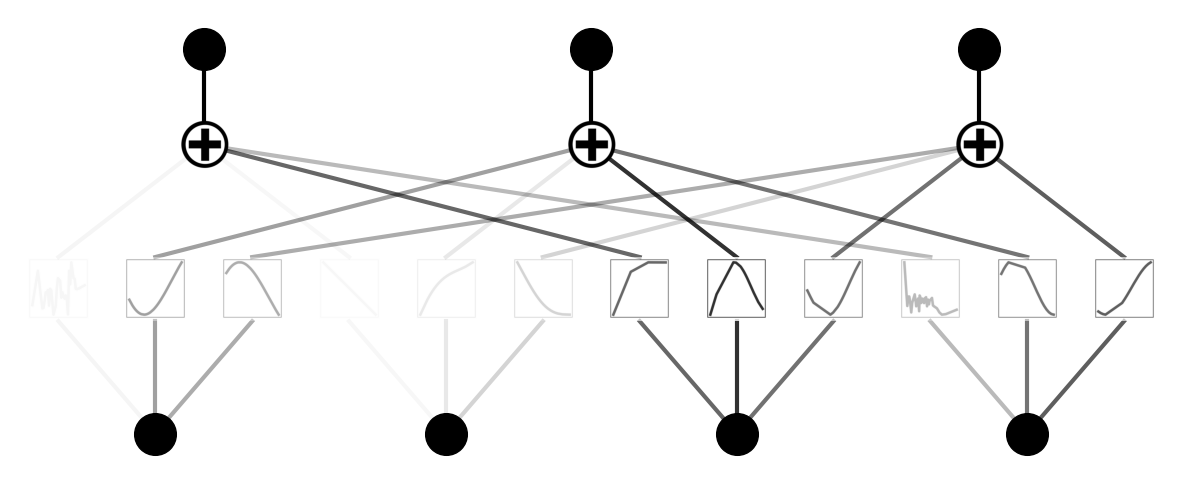

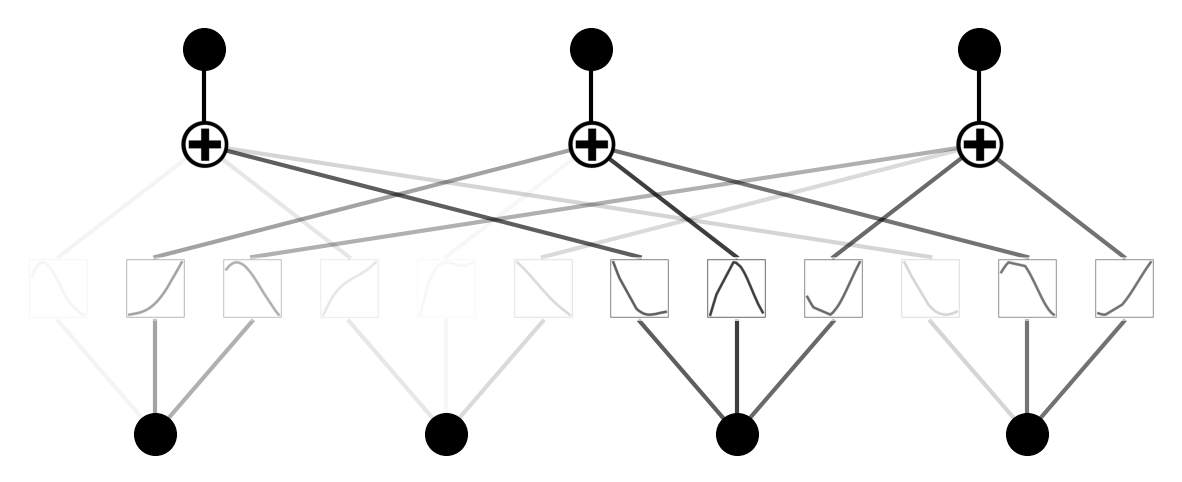

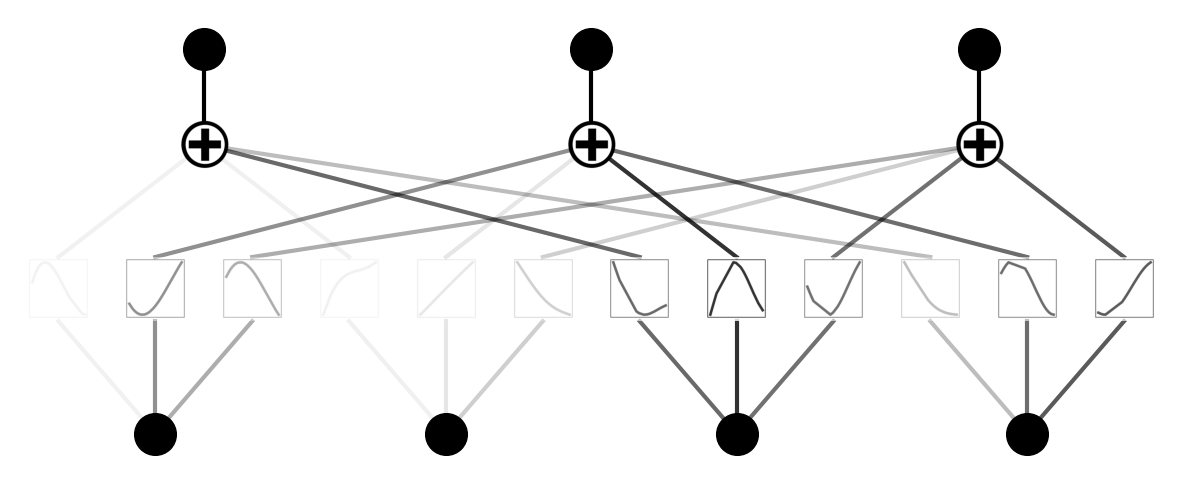

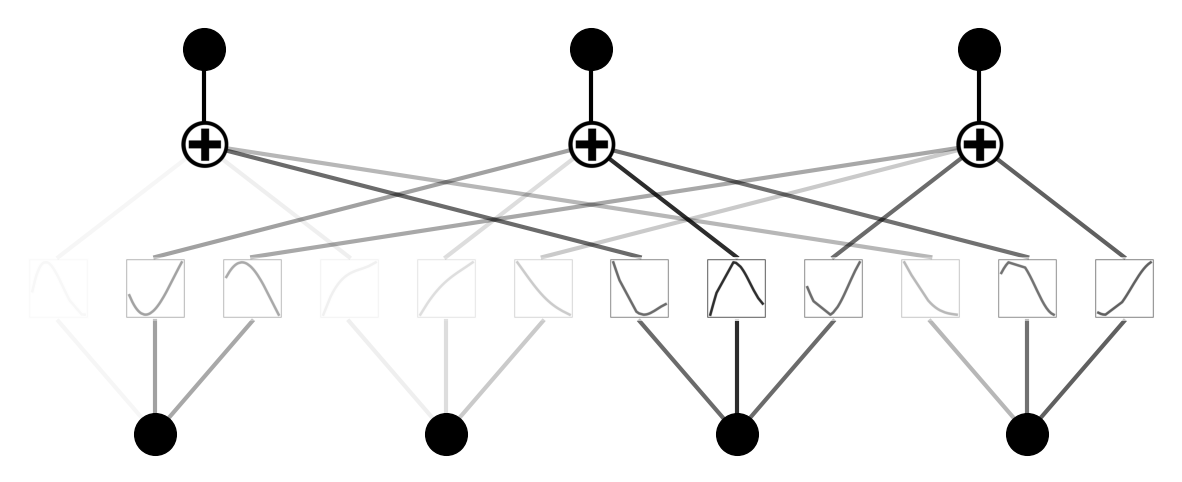

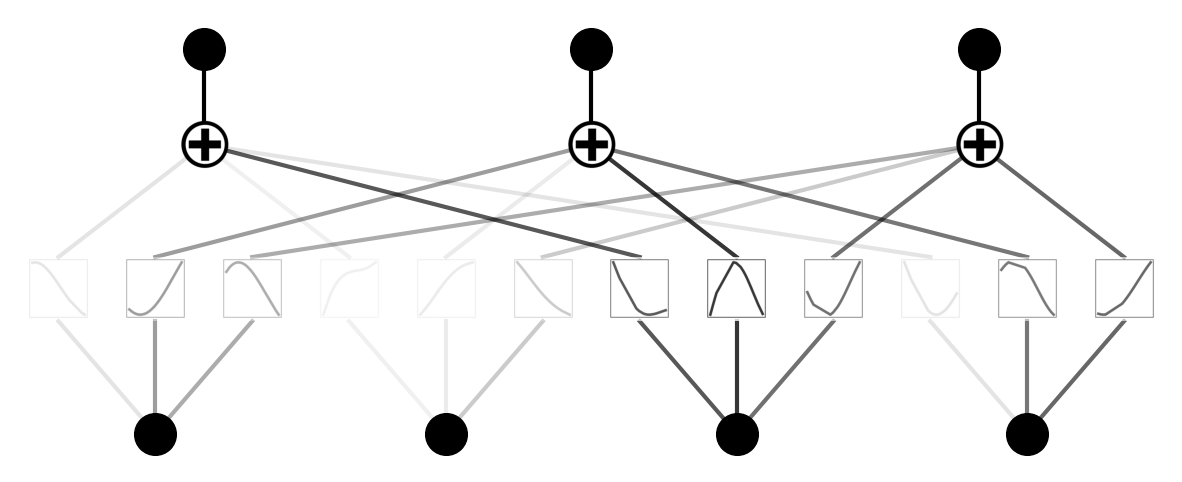

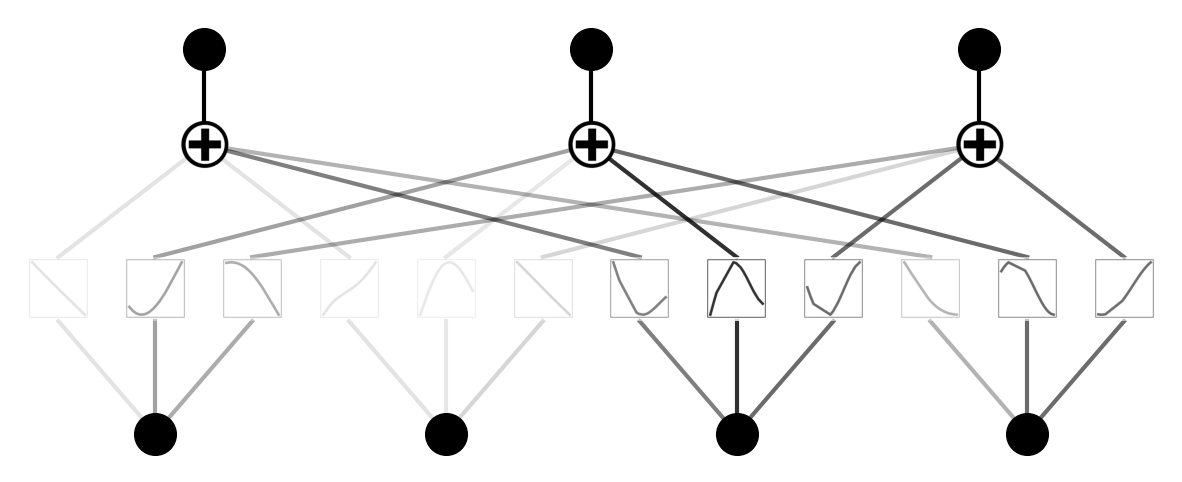

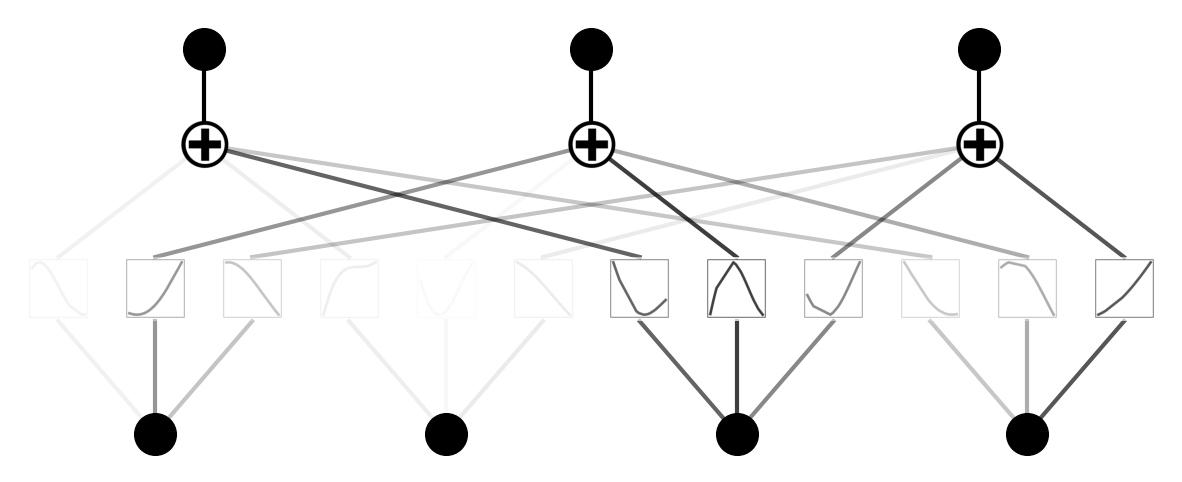

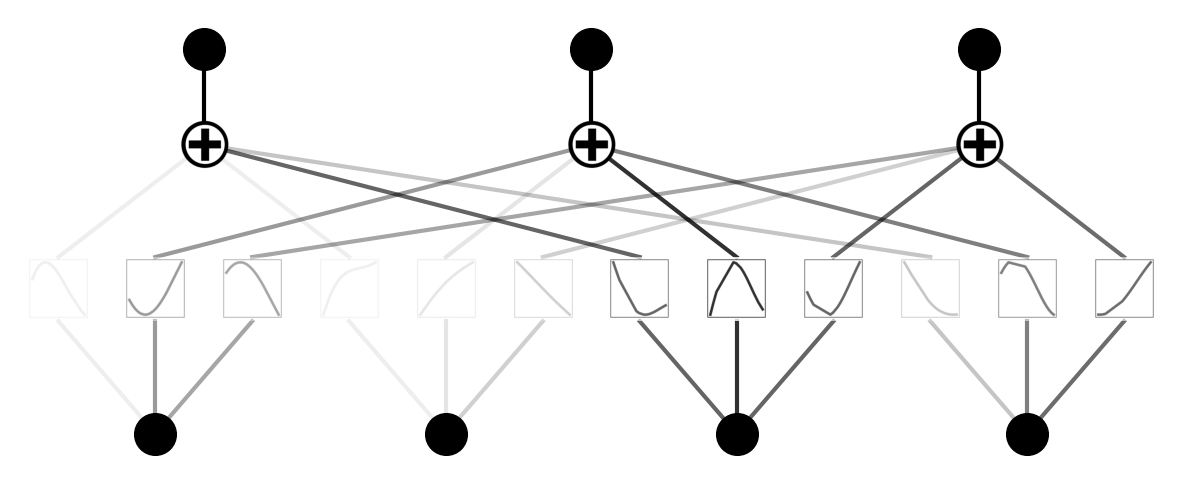

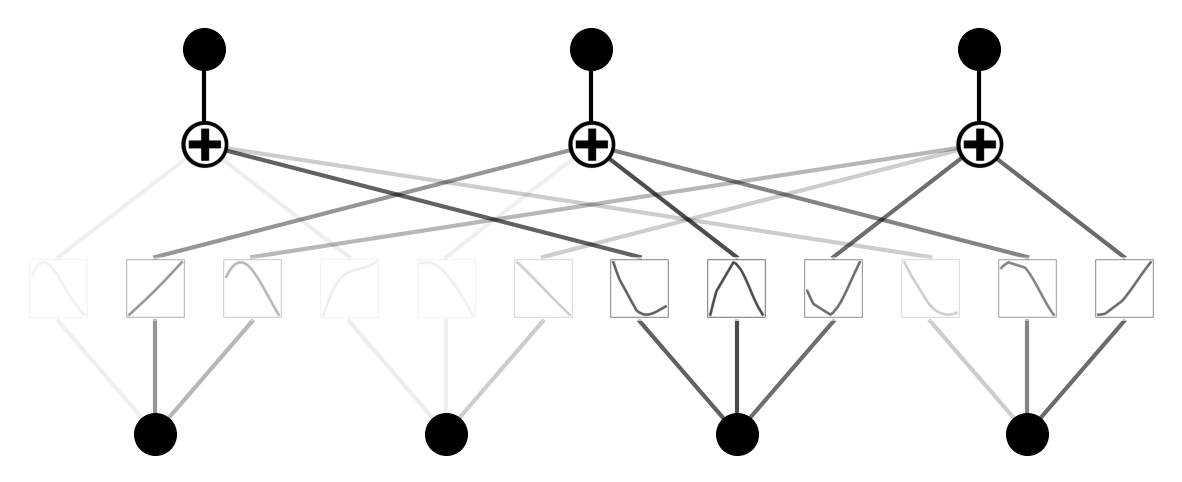

In [56]:
train_f1_score_list = [0] 
test_f1_score_list  = [0] 

train_losses = [] 
test_losses = []   
for i in range(1 , 30) :
    model = KAN(width=[ 4, 3 ],grid = 3 , k = i , device= device) 

    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))
    
    def precision(y_true, y_pred):
        # Precision = TP / (TP + FP)
        true_positives = torch.sum((y_pred == 1) & (y_true == 1))
        predicted_positives = torch.sum(y_pred == 1)
        return true_positives / (predicted_positives + 1e-8)  # Add small epsilon to avoid division by zero

    def recall(y_true, y_pred):
        # Recall = TP / (TP + FN)
        true_positives = torch.sum((y_pred == 1) & (y_true == 1))
        actual_positives = torch.sum(y_true == 1)
        return true_positives / (actual_positives + 1e-8)

    def f1_score(y_true, y_pred):
        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        prec = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return 2 * (prec * rec) / (prec + rec + 1e-8)

    def train_f1_score():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]                  
        return f1_score(y_true, y_pred)

    def test_f1_score():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return f1_score(y_true, y_pred)

    def train_precision():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]
        return precision(y_true, y_pred)

    def test_precision():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return precision(y_true, y_pred)

    def train_recall():
        y_pred = torch.round(model(dataset['train_input'])[:, 0])
        y_true = dataset['train_label'][:, 0]
        return recall(y_true, y_pred)

    def test_recall():
        y_pred = torch.round(model(dataset['test_input'])[:, 0])
        y_true = dataset['test_label'][:, 0]
        return recall(y_true, y_pred)
    

    results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_f1_score, test_f1_score) );  
   
    train_f1_score_list.append( results["train_f1_score"][-1] )  
    test_f1_score_list.append( results['test_f1_score'][-1] )       
    
    train_losses += results['train_loss']                     
    test_losses += results['test_loss'] 
    model.plot(scale = 1.5)  

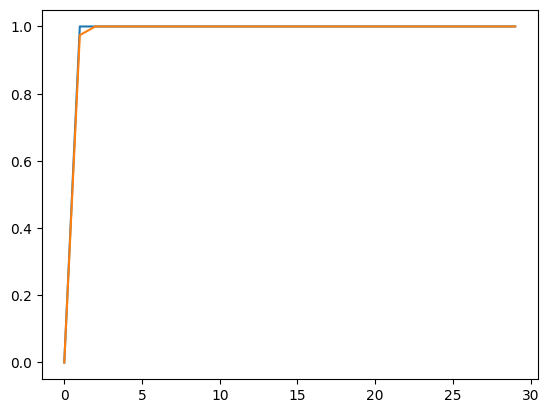

In [57]:
plt.plot(train_f1_score_list) 
plt.plot(test_f1_score_list) 